## Курсовой проект Real Estate Price Prediction

#### Аверьянов Алексей

Тетрадка содержит решение итогового курсового проекта `Real Estate Price Prediction` по курсу `Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn`

### Задача

Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки сдачи:
Cдать проект нужно в течение 72 часов после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

Описание датасета:
Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

### Общий алгоритм решения

В процессе решения мной были проведены около сотни различных тестов и экспериментов по: 
   1. обработке и очистке исходных данных, 
   2. выделению главных компонент,
   3. генерации новых и отборы эффективных признаков
   4. использованию различных алгоритмов и библиотек
   и т.д.
   
Я пробовал строить решения как опираясь на `baseline` преподавателя, так и на собственные варианты. В результате я остановился на текущем решении. 

В качестве алгоритма для обучения был выбран градиентный бустинг и его реализация в библиотеке `CatBoost от Яндекс`. Алгоритм показал наилучшие результаты и плюс оказался очень удобным в использовании. Умеет работать с категориальными признаками и не требует особого тюнинга параметров.


**Схематично алгоритм состоит из следующих шагов:**
1. Минимальная очистка данных (намного меньше, чем в baseline)
2. Генерация новых признаков, которые показали себя наиболее эффективно
3. Разбиение выборки на train и valid, обучение модели и оценка результатов
4. Прогнозирование на выборке test и сохранение результатов прогноза

### 0. Подключаем библиотеки, загружаем данные

In [70]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-ticks')
sns.style = "seaborn-ticks"
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor

In [71]:
DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'

In [72]:
df_train = pd.read_csv(DATASET_PATH, index_col='Id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

In [73]:
df_test = pd.read_csv(TEST_DATASET_PATH, index_col='Id')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     3959 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   object 
 10  Ecology_3      5000 non-null   object 
 11  Social_1       5000 non-null   int64  
 12  Social_2       5000 non-null   int64  
 13  Social_3       5000 non-null   int64  
 14  Healthcare_1   2623 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   object 
dtypes: fl

In [74]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.000,50.401,43.588,0.000,20.000,36.000,75.000,209.000
Rooms,10000.000,1.891,0.840,0.000,1.000,2.000,2.000,19.000
Square,10000.000,56.316,21.059,1.137,41.775,52.513,65.901,641.065
LifeSquare,7887.000,37.200,86.241,0.371,22.770,32.781,45.129,7480.592
KitchenSquare,10000.000,6.273,28.561,0.000,1.000,6.000,9.000,2014.000
Floor,10000.000,8.527,5.241,1.000,4.000,7.000,12.000,42.000
HouseFloor,10000.000,12.609,6.776,0.000,9.000,13.000,17.000,117.000
HouseYear,10000.000,3990.166,200500.261,1910.000,1974.000,1977.000,2001.000,20052011.000
Ecology_1,10000.000,0.119,0.119,0.000,0.018,0.075,0.196,0.522
Social_1,10000.000,24.687,17.533,0.000,6.000,25.000,36.000,74.000


### 1.Минимальная очистка и обработка данных

In [75]:
def draw_boxplot_graphics(df:pd.core.frame.DataFrame, columns:list):
    'Рисует графики BoxPlots для переденных колонок'   
    for col in columns:
        plt.figure(figsize=(14, 1))
        sns.boxplot(data=df[col].values, orient='h', palette='Set2')
        plt.xlabel(col,fontdict={'fontsize':14})   
        
    plt.show()

#### Чистим выбросы

Уберем самые "страшные" выбросы, на Boxplot ниже, проверим, их отсутствие. Удаляем, так как обучить модель "чему-то хорошему" мы на них не сможем точно.

In [76]:
df_train.drop(df_train[df_train['Rooms'] > 7].index, inplace=True)
df_train.drop(df_train[df_train['Square'] > 250].index, inplace=True)
df_train.drop(df_train[df_train['LifeSquare'] > 200].index, inplace=True)
df_train.drop(df_train[df_train['KitchenSquare'] > 50].index, inplace=True)
df_train.drop(df_train[df_train['Floor'] > 30].index, inplace=True)
df_train.drop(df_train[df_train['HouseFloor'] > 60].index, inplace=True)
df_train.drop(df_train[df_train['HouseYear'] > 2020].index, inplace=True)
df_train.drop(df_train[df_train['HouseYear'] < 1920].index, inplace=True)

In [77]:
print('Осталось строк: ', df_train.shape[0]) 
print(f'Удалено: {round((1 - df_train.shape[0] / 10000) * 100,2)}%')

Осталось строк:  9940
Удалено: 0.6%


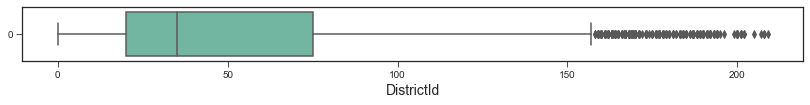

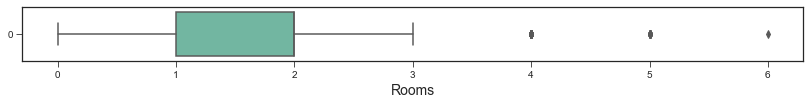

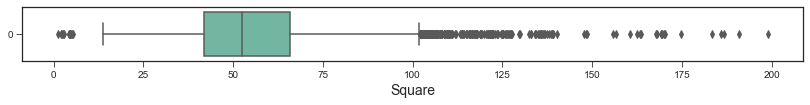

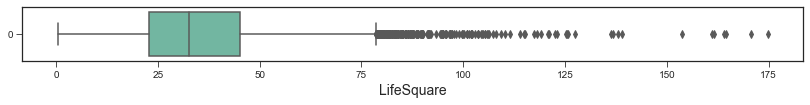

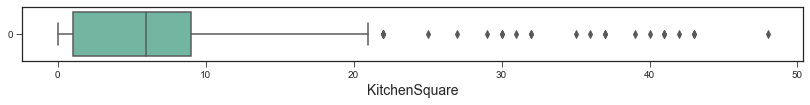

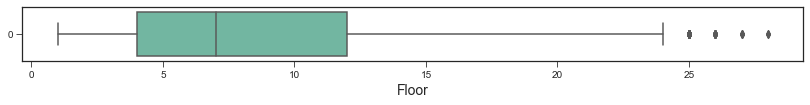

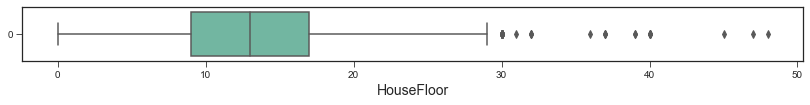

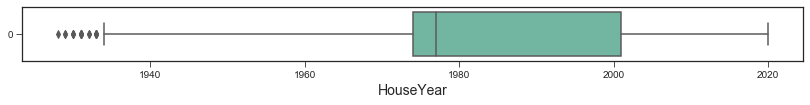

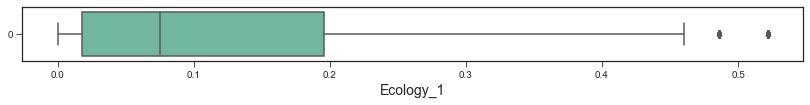

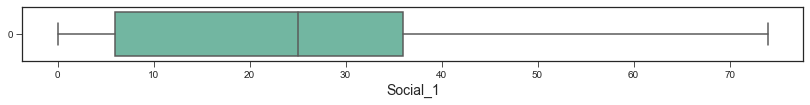

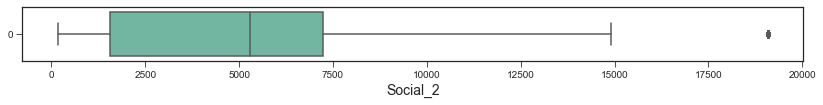

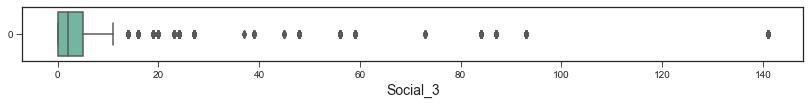

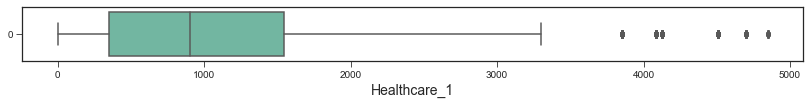

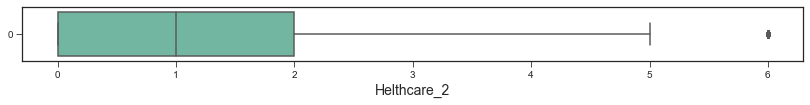

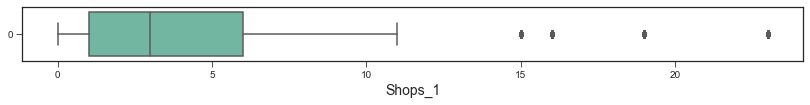

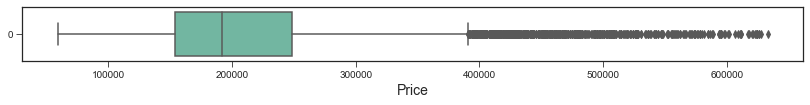

In [78]:
features_list = df_train.select_dtypes(exclude='object').columns.tolist()
draw_boxplot_graphics(df_train, features_list)

#### LifeSquare

Заполняем пропуски `LifeSquare` медианой

In [79]:
df_train['LifeSquare'].fillna(value=df_train['LifeSquare'].median(), inplace=True)

df_test['LifeSquare'].fillna(value=df_train['LifeSquare'].median(), inplace=True)

#### Ecology_2, Ecology_3, Shops_2

Категориальные переменные `Ecology_2, Ecology_3, Shops_2` имеют по два значения. Переведем их к dummy-виду

In [80]:
print(df_train['Ecology_2'].value_counts())
print(df_train['Ecology_3'].value_counts())
print(df_train['Shops_2'].value_counts())

B    9843
A      97
Name: Ecology_2, dtype: int64
B    9668
A     272
Name: Ecology_3, dtype: int64
B    9119
A     821
Name: Shops_2, dtype: int64


In [81]:
dummy_features = ['Ecology_2', 'Ecology_3', 'Shops_2']

df_train[dummy_features] = df_train[dummy_features].replace({'A':0, 'B':1})

for feat in dummy_features:
    print(df_train[feat].value_counts())

1    9843
0      97
Name: Ecology_2, dtype: int64
1    9668
0     272
Name: Ecology_3, dtype: int64
1    9119
0     821
Name: Shops_2, dtype: int64


In [82]:
df_test[dummy_features] = df_test[dummy_features].replace({'A':0, 'B':1})

for feat in dummy_features:
    print(df_test[feat].value_counts())

1    4952
0      48
Name: Ecology_2, dtype: int64
1    4851
0     149
Name: Ecology_3, dtype: int64
1    4588
0     412
Name: Shops_2, dtype: int64


#### Healthcare_1

Удалим `Healthcare_1`. Как заполнять пропуски не знаю. Но оставим признак, было заполнено или нет

In [83]:
def fill_healthcare_1(x):
    if pd.notna(x):
        return 1
    else:
        return 0

In [84]:
df_train['Healthcare_1_filled'] = df_train['Healthcare_1'].apply(fill_healthcare_1)
df_train.drop('Healthcare_1', axis=1, inplace=True)
print(df_train['Healthcare_1_filled'].value_counts())

1    5167
0    4773
Name: Healthcare_1_filled, dtype: int64


In [85]:
df_test['Healthcare_1_filled'] = df_test['Healthcare_1'].apply(fill_healthcare_1)
df_test.drop('Healthcare_1', axis=1, inplace=True)
print(df_test['Healthcare_1_filled'].value_counts())

1    2623
0    2377
Name: Healthcare_1_filled, dtype: int64


### 2.Генерация новых признаков

#### Логарифмируем некоторые признаки

Попробуем логарифмировать некоторые признаки. Как увидим при дальнейше моделировании, некоторые из них попадут в список наиболее важных

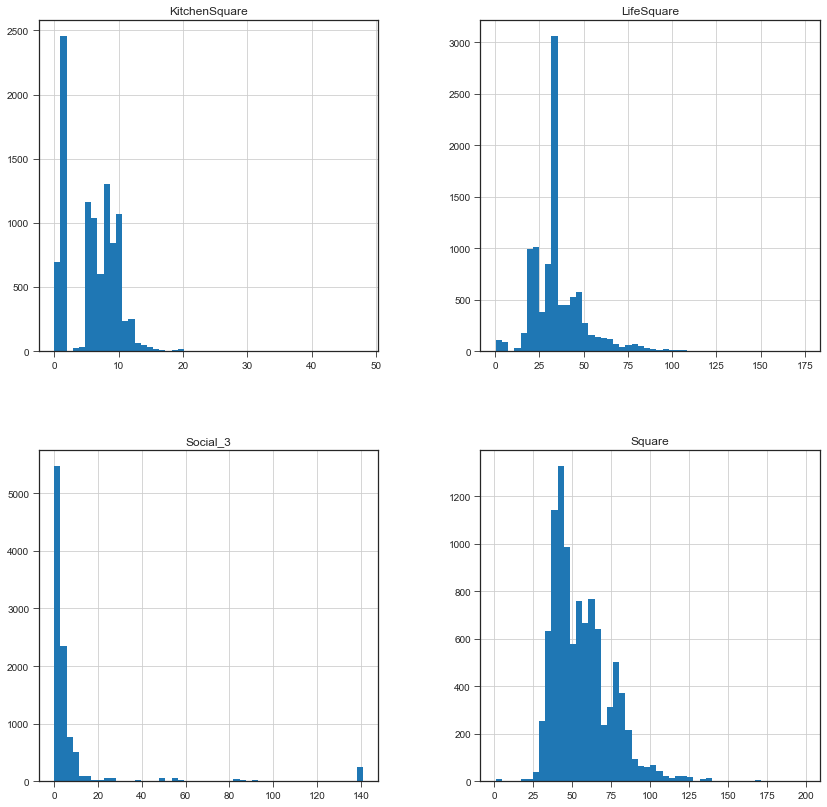

In [87]:
feature_num_names = ['Square', 'LifeSquare', 'KitchenSquare', 'Social_3']

df_train[feature_num_names].hist(figsize=(14,14), bins=50, grid=True)
plt.show()

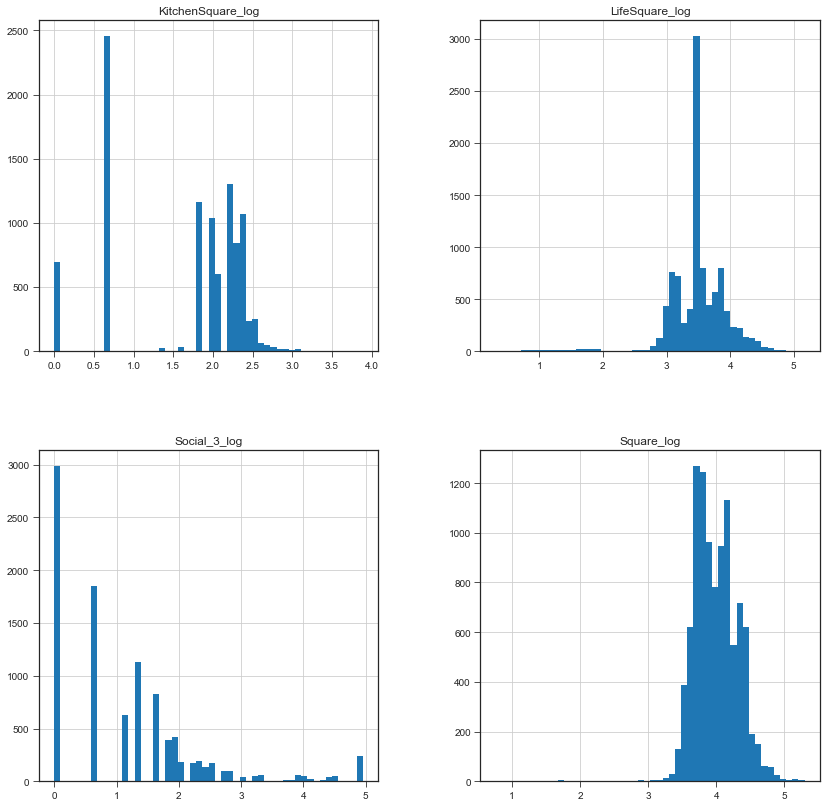

In [88]:
feature_log_names = []
for f in feature_num_names:
    df_train[f + '_log'] = np.log(df_train[f]+1)
    df_test[f + '_log'] = np.log(df_test[f]+1)
    feature_log_names.append(f + '_log')
    
df_train[feature_log_names].hist(figsize=(14,14), bins=50, grid=True)
plt.show()

#### Создадим новых признаки

In [89]:
#функции автоматизируют создание признаков вида "PriceOneSquareByDistrictId"

def add_feat_by(groupby_feat, agg_feat, train, test):

    new_feat_name = agg_feat + 'By' + groupby_feat
    price_by = train.groupby([groupby_feat], as_index=False)\
                        .agg({agg_feat:'median'})\
                        .rename(columns={agg_feat:new_feat_name})

    train = train.merge(price_by, on=[groupby_feat], how='left').set_index(train.index)
    test = test.merge(price_by, on=[groupby_feat], how='left').set_index(test.index)
    
    test[new_feat_name].fillna(value=train[new_feat_name].median(), inplace=True)
    
    return train, test


def add_additional_features(groupby_features, agg_features, train, test):
    for agg_feat in agg_features:
        for groupby_feat in groupby_features:          
            train, test = add_feat_by(groupby_feat, agg_feat, train, test)
            
    return train, test

In [90]:
df_train['PriceOneRoom'] = df_train['Price'] / df_train['Rooms']
df_train['PriceOneSquare'] = df_train['Price'] / df_train['Square']

groupby_features = ['DistrictId', 'HouseYear', 'Ecology_1', 'Floor', 'Social_1', 'Social_3', 'Shops_1']
agg_features = ['PriceOneRoom', 'PriceOneSquare']

df_train, df_test = add_additional_features(groupby_features, agg_features, df_train, df_test)

df_train.drop('PriceOneRoom', axis=1, inplace=True)
df_train.drop('PriceOneSquare', axis=1, inplace=True)

In [91]:
df_train.shape, df_test.shape

((9940, 37), (5000, 36))

In [92]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9940 entries, 14038 to 6306
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DistrictId                  9940 non-null   int64  
 1   Rooms                       9940 non-null   float64
 2   Square                      9940 non-null   float64
 3   LifeSquare                  9940 non-null   float64
 4   KitchenSquare               9940 non-null   float64
 5   Floor                       9940 non-null   int64  
 6   HouseFloor                  9940 non-null   float64
 7   HouseYear                   9940 non-null   int64  
 8   Ecology_1                   9940 non-null   float64
 9   Ecology_2                   9940 non-null   int64  
 10  Ecology_3                   9940 non-null   int64  
 11  Social_1                    9940 non-null   int64  
 12  Social_2                    9940 non-null   int64  
 13  Social_3                    9

### 3.Обучение модели и оценка результатов

In [93]:
#функция позволяет удобно сравнить R2 и MAE на тестовой и валидационной выборке
def evaluate_preds(true_values_train, pred_values_train, true_values_test, pred_values_test):
    print('Train:\t' + 'R2 = ' + str(round(r2_score(true_values_train, pred_values_train), 5)) + 
          '\tMAE = ' + str(round(mean_absolute_error(true_values_train, pred_values_train), 5)) +
          '\n' +
          'Test:\t' + 'R2 = ' + str(round(r2_score(true_values_test, pred_values_test), 5)) +
          '\tMAE = ' + str(round(mean_absolute_error(true_values_test, pred_values_test), 5))
         )
    
    plt.figure(figsize=(16, 6))
       
    plt.subplot(121)
    sns.scatterplot(x=pred_values_train, y=true_values_train)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train: True vs Predicted values');
    
    plt.subplot(122)
    sns.scatterplot(x=pred_values_test, y=true_values_test)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test: True vs Predicted values');

#### CatBoost

CatBoost умеет неплохо работать с категориальными переменными (не нужно их специально кодировать), умеет работать с бинарными переменными и даже с пропусками.

Но эксперименты показали, что лучший результат получается, если отметить как категориальные только `'DistrictId', 'Floor', 'HouseFloor'`, а остальные заполнить и закодировать как мы сделали на этапе очистки.

In [94]:
cat_features = ['DistrictId', 'Floor', 'HouseFloor']

df_train[cat_features] = df_train[cat_features].astype('str')
df_test[cat_features] = df_test[cat_features].astype('str')

In [95]:
X = df_train.drop('Price', axis=1)
y = df_train['Price']

X.shape, y.shape

((9940, 36), (9940,))

In [96]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((7455, 36), (2485, 36), (7455,), (2485,))

In [97]:
ctb = CatBoostRegressor(random_seed=17, eval_metric='R2', silent=True, use_best_model=False)

CatBoost умеет рисовать неплохой график в процессе обучения. Но в сохраненном блокноте он не отображается

In [98]:
%%time
ctb.fit(X_train, y_train,
        cat_features=cat_features, eval_set=(X_valid, y_valid), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 50.1 s


#### Оцениваем результаты

Train:	R2 = 0.88615	MAE = 19735.26492
Test:	R2 = 0.78075	MAE = 25858.65531


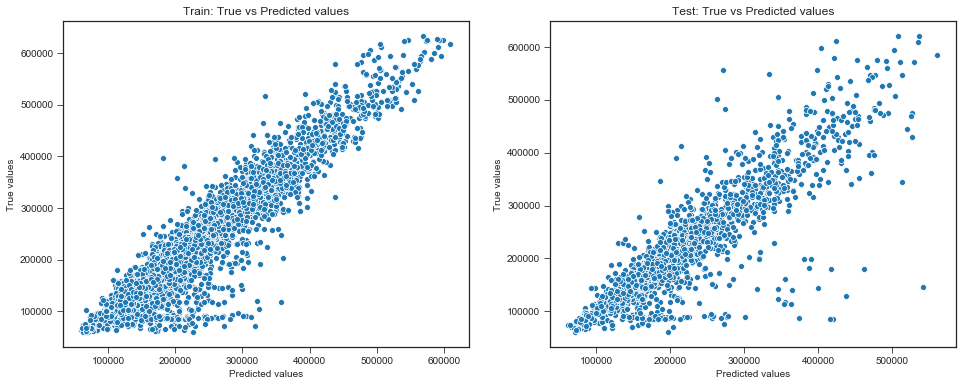

In [99]:
y_train_preds = ctb.predict(X_train)
y_valid_preds = ctb.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

#### Смотрим наиболее важные признаки

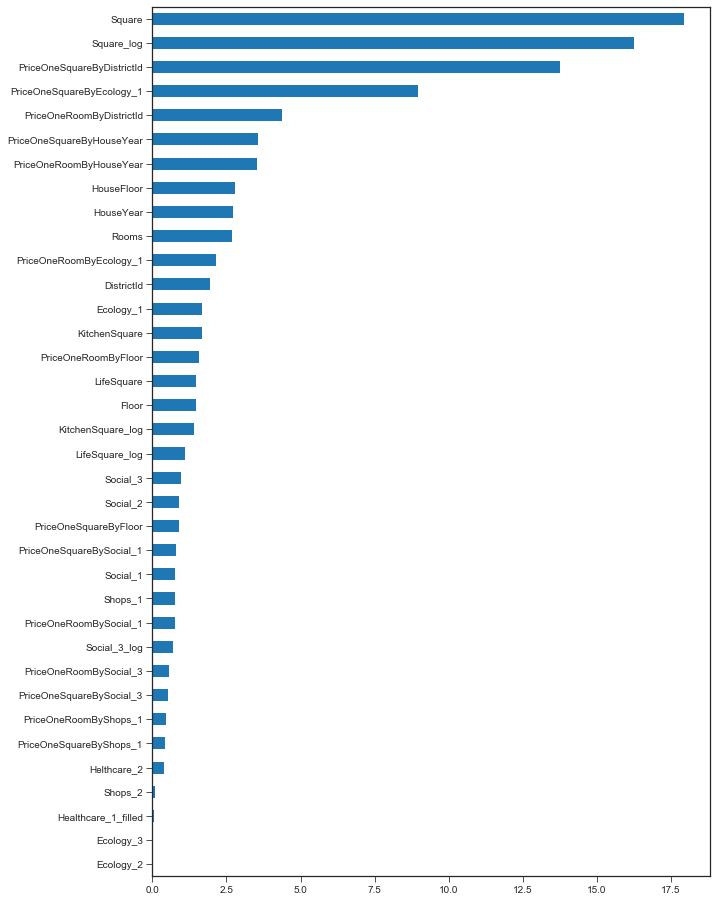

In [66]:
importances = ctb.feature_importances_
feat_importances = pd.Series(importances, index=X_train.columns)
feat_importances.sort_values(ascending=True, inplace=True)

feat_importances.plot(kind='barh', figsize=(10, 16));

### 4.Обучение тестовой выборки и сохранение результата

In [67]:
%%time
ctb.fit(X, y,
        cat_features=cat_features)

Wall time: 54.8 s


In [68]:
y_pred = ctb.predict(df_test)

preds = pd.DataFrame()
preds['Id'] = df_test.index
preds['Price'] = y_pred

In [69]:
preds.to_csv('AAveryanov_predictions.csv', index=False)